In [48]:
import sys
import shutil
sys.path.append('../dependencies/')
import pyemu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import yaml
import pathlib as pl
from flopy.plot import styles as fpstyles
from shapely.geometry import Point
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


### loading up some background information about the project

In [2]:
wkdir = pl.Path('.')
template_dir = pl.Path('./tmpdir')
sen_template_dir = pl.Path('./tmpdir_sen')
    
input_yml = 'TestExample.yml'
with open(wkdir / input_yml, 'r') as ifp:
    indat = yaml.safe_load(ifp)
nhd = gp.read_file(wkdir / 'flowlines_clipped.geojson')

In [3]:
well_keys = [i for i in indat.keys() if i.startswith('well_')]
app_keys = [[j for j in indat[i].keys() if j.startswith('stream_apportionment')]
                     for i in well_keys]
pending_wells = [i for i in well_keys if 'pending' in indat[i]['status']]
allkeys = dict(zip(well_keys, app_keys))
pending_wells

['well_93832']

### get all the locations for results plotting

In [4]:
indat[pending_wells[0]]

{'name': '93832',
 'status': 'pending',
 'loc': {'x': 89.298, 'y': 44.465700000000005},
 'Q': 485.0,
 'pumping_days': 90,
 'stream_apportionment159': {'name': 'TomorrowRiver:93832',
  'apportionment': 0.16096118707682489},
 'stream_response': ['TomorrowRiver:93832'],
 'dd_response': []}

In [5]:
pending_wells_gdf = gp.GeoDataFrame(index=pending_wells,data=
                        {'well_id':pending_wells,
                        'geometry':[Point(-indat[cw]['loc']['x'],
                                        indat[cw]['loc']['y']) for cw in pending_wells]},
                        crs=4326).to_crs(nhd.crs)

/Users/mnfienen/miniforge3/envs/hca/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/Users/mnfienen/miniforge3/envs/hca/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [6]:
pending_well_loc = Point(-indat[pending_wells[0]]['loc']['x'],
                        indat[pending_wells[0]]['loc']['y'])

In [7]:
existing_wells_gdf = gp.GeoDataFrame(index=well_keys,data=
                        {'app':[i[0] for i in app_keys],
                         'Q':[indat[cw]['Q'] for cw in well_keys],
                        'geometry':[Point(-indat[cw]['loc']['x'],
                                        indat[cw]['loc']['y']) for cw in well_keys]},
                        crs=4326).to_crs(nhd.crs)
existing_wells_gdf['lookup_key'] = [f"{k}__{v}" for k,v, in zip(existing_wells_gdf.index,
                                                                existing_wells_gdf['app'])]

<Axes: >

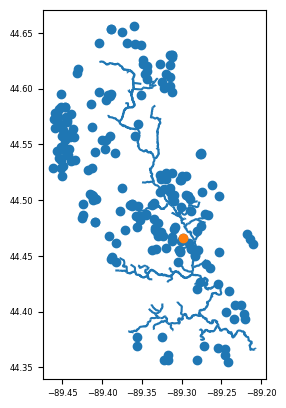

In [8]:
ax = existing_wells_gdf.to_crs(nhd.crs).plot()
nhd.plot(ax=ax)
pending_wells_gdf.plot(ax=ax)

# Method of Morris First

In [9]:
pst_name='./MASTER_SEN/global_sens_morris.pst'

In [10]:
pst = pyemu.Pst(pst_name)

error parsing metadata from 'obsnme', continuing


In [11]:
morris_sum_file = pst_name.replace('.pst','.msn')

In [12]:
morris_df = pd.read_csv(morris_sum_file, index_col=0).T.rename(columns={'global_s':'Storage','global_t':'Transmissivity',
                                                                       'well_1013__stream_apportionment121':'Existing Depletion'}).T
morris_df

,n_samples,sen_mean,sen_mean_abs,sen_std_dev
parameter_name,,,,
Storage,12.0,30.19700,37.2388,61.8039
Transmissivity,12.0,-33.81920,65.8534,108.4490
Existing Depletion,12.0,5.94226,12.4111,21.0622


Text(0, 0.5, 'Mean Absolute Sensitivity')

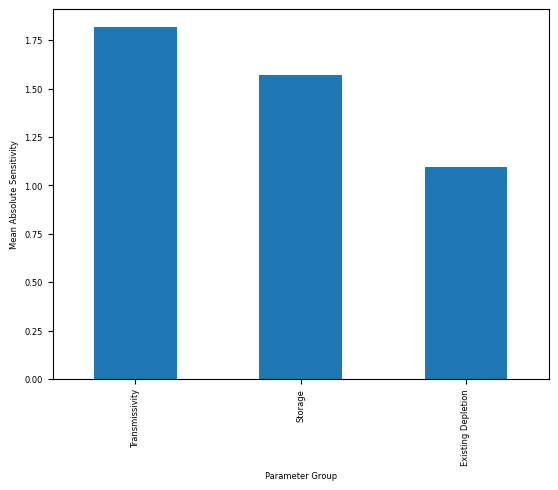

In [13]:
ax = morris_df.sort_values(by='sen_mean_abs',ascending=False).iloc[:25].sen_mean_abs.apply(np.log10).plot.bar()
plt.xlabel('Parameter Group')
plt.ylabel('Mean Absolute Sensitivity')


# Morris Distributed

In [14]:
pst_dist_name='./MASTER_SEN_DISTRIB/global_sens_morris.distributed.pst'
morris_sum_file_dist = pst_dist_name.replace('.pst','.msn')

In [15]:
morris_df_dist = pd.read_csv(morris_sum_file_dist, index_col=0)
morris_df_dist

,n_samples,sen_mean,sen_mean_abs,sen_std_dev
parameter_name,,,,
global_s,12,5.786370,45.931000,76.631100
global_t,12,-15.677500,85.810100,126.210000
well_1013__stream_apportionment121,12,-0.095817,0.149062,0.282110
well_1302__stream_apportionment14,12,-0.028279,0.042455,0.086517
well_1323__stream_apportionment48,12,0.006489,0.013466,0.029618
...,...,...,...,...
well_92885__stream_apportionment92,12,-0.004214,0.009326,0.019672
well_92981__stream_apportionment24,12,-0.038511,0.072223,0.149138
well_93141__stream_apportionment78,12,-0.342400,0.896520,1.354070


In [16]:
morris_distributed_gdf = existing_wells_gdf.copy()
morris_distributed_gdf = morris_distributed_gdf.merge(morris_df_dist, 
                                                    right_index=True, 
                                                    left_on='lookup_key')
morris_distributed_gdf['msize'] = morris_distributed_gdf['sen_mean_abs']*150
morris_distributed_gdf['qsize'] = morris_distributed_gdf['Q']/2


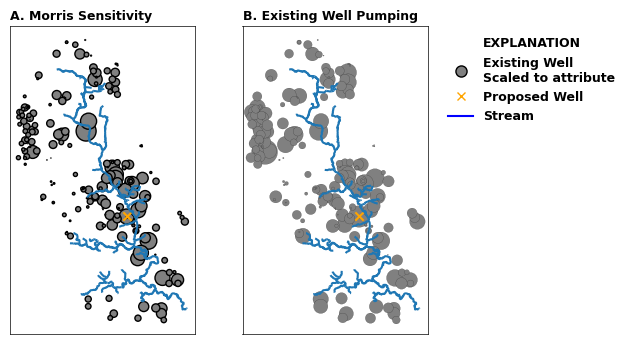

In [66]:
with fpstyles.USGSPlot():
    fig, ax = plt.subplots(1,2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(6,4), sharey=True)
    morris_distributed_gdf.plot(markersize='msize', edgecolor='k', color='grey', ax=ax[0])
    nhd.plot(ax=ax[0])
    
    pending_wells_gdf.plot(color='orange', marker = 'x',  ax=ax[0])
    morris_distributed_gdf.plot(markersize='qsize', lw=.1, edgecolor='k', color='grey',ax=ax[1])
    nhd.plot(ax=ax[1])
    pending_wells_gdf.plot(color='orange', marker = 'x', ax=ax[1])
    for cax in ax:
        cax.set_xticks([])
        cax.set_yticks([])
    h = [
        Line2D([0],[0], color='grey', markeredgecolor='k',marker='o', ls='', ms=8),
        Line2D([0],[0], color='orange', marker='x', ls=''),
        Line2D([0],[0], color='blue', marker=''),
        
    ]
    fpstyles.heading(ax[0], heading="Morris Sensitivity",   letter='A')
    fpstyles.heading(ax[1], heading="Existing Well Pumping",   letter='B')
    fpstyles.graph_legend( handles = h,
                          labels = ['Existing Well\nScaled to attribute',
                                    'Proposed Well',
                                    "Stream"],
                          bbox_to_anchor=(1.05, 1))


# And now Соболь Distributed

In [18]:
pst_name='./MASTER_SEN_DISTRIB/global_sens_sobol.distributed.pst'
si = pd.read_csv(pst_name.replace(".pst",".sobol.si.csv"), index_col=0).T
si

output,phi,tomorrowriver:total_existing:bdpl,tomorrowriver:986:bdpl,tomorrowriver:92981:bdpl,tomorrowriver:92885:bdpl,tomorrowriver:92808:bdpl,tomorrowriver:92743:bdpl,tomorrowriver:92724:bdpl,tomorrowriver:92696__1824,tomorrowriver:92696__1823,...,tomorrowriver:70974__1658,tomorrowriver:23648:bdpl,tomorrowriver:70974__1618,tomorrowriver:24021:bdpl,tomorrowriver:70974__1499,tomorrowriver:92696__1643,tomorrowriver:92696__1761,tomorrowriver:92696__1631,tomorrowriver:70974__1650,tomorrowriver:23616:bdpl
global_s,0.150487,0.065739,0.104320,0.077513,0.074175,0.088387,0.037089,0.0,0.039121,0.039159,...,0.018220,0.066249,0.018621,0.151457,0.014984,0.051948,0.041994,0.053467,0.018308,0.047725
global_t,0.710172,0.957758,0.828963,0.941045,0.873831,0.738780,0.795311,0.0,0.694797,0.694529,...,0.940271,0.955771,0.942815,0.791550,0.949102,0.569228,0.673114,0.547004,0.940802,0.876731
well_1013__stream_apportionment121,-0.000152,-0.000083,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_1302__stream_apportionment14,-0.000093,-0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_1323__stream_apportionment48,0.000009,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_92885__stream_apportionment92,-0.000018,-0.000009,0.000000,0.000000,-0.005456,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_92981__stream_apportionment24,-0.000091,0.000036,0.000000,0.009760,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_93141__stream_apportionment78,0.002413,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_93832__stream_apportionment159,-0.001142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
sti = pd.read_csv(pst_name.replace(".pst",".sobol.sti.csv"), index_col=0).T
sti

output,phi,tomorrowriver:total_existing:bdpl,tomorrowriver:986:bdpl,tomorrowriver:92981:bdpl,tomorrowriver:92885:bdpl,tomorrowriver:92808:bdpl,tomorrowriver:92743:bdpl,tomorrowriver:92724:bdpl,tomorrowriver:92696__1824,tomorrowriver:92696__1823,...,tomorrowriver:70974__1658,tomorrowriver:23648:bdpl,tomorrowriver:70974__1618,tomorrowriver:24021:bdpl,tomorrowriver:70974__1499,tomorrowriver:92696__1643,tomorrowriver:92696__1761,tomorrowriver:92696__1631,tomorrowriver:70974__1650,tomorrowriver:23616:bdpl
global_s,2.371490e-01,8.551930e-02,0.120295,0.102942,0.107380,0.123972,0.055428,0.0,0.047326,0.047298,...,0.064296,0.092828,0.064403,0.162954,0.064166,0.040477,0.045290,0.040151,0.064317,0.064842
global_t,9.043770e-01,9.786800e-01,0.871841,0.952769,0.951959,0.879427,0.803898,0.0,0.656199,0.656099,...,0.997404,0.957513,0.997754,0.896066,1.001060,0.607574,0.648022,0.598778,0.997479,0.935937
well_1013__stream_apportionment121,4.281540e-06,8.825070e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_1302__stream_apportionment14,2.736330e-07,6.329940e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_1323__stream_apportionment48,1.907100e-08,4.096000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_92885__stream_apportionment92,1.445790e-08,3.193760e-09,0.000000,0.000000,0.036150,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_92981__stream_apportionment24,8.414540e-07,1.822820e-07,0.000000,0.010732,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_93141__stream_apportionment78,1.661050e-04,6.913530e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
well_93832__stream_apportionment159,1.004240e-04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


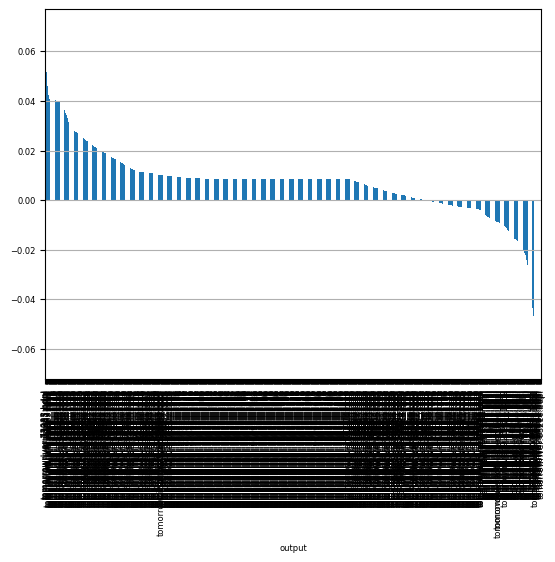

In [20]:
sti.iloc[1:].sum().iloc[1:].sort_values(ascending=False).astype(np.float64).apply(np.log10).plot.bar().grid(axis='y')

In [21]:
sti.iloc[2:].sum()

output
phi                                  0.002857
tomorrowriver:total_existing:bdpl    0.000963
tomorrowriver:986:bdpl               0.026592
tomorrowriver:92981:bdpl             0.010732
tomorrowriver:92885:bdpl             0.036150
                                       ...   
tomorrowriver:92696__1643            0.407847
tomorrowriver:92696__1761            0.348904
tomorrowriver:92696__1631            0.419476
tomorrowriver:70974__1650            0.022791
tomorrowriver:23616:bdpl             0.089876
Length: 940, dtype: float64

In [22]:
sobol_distributed_gdf = existing_wells_gdf.copy()
sobol_distributed_gdf = sobol_distributed_gdf.merge(morris_df_dist, 
                                                    right_index=True, 
                                                    left_on='lookup_key')
sobol_distributed_gdf['msize'] = sobol_distributed_gdf['sen_mean_abs']*150
sobol_distributed_gdf['qsize'] = sobol_distributed_gdf['Q']/2

# Sobol' sensitivity

In [23]:
pst_name='./MASTER_SEN/global_sens_sobol.pst'
si = pd.read_csv(pst_name.replace(".pst",".sobol.si.csv")).rename(columns={'output':'output','global_s':'Storage','global_t':'Transmissivity',
                                                                    'well_1013__stream_apportionment121':'Existing Depletion'})

In [24]:
si

,output,Storage,Transmissivity,Existing Depletion
0,phi,0.143852,0.678086,-0.010463
1,tomorrowriver:total_existing:bdpl,0.068239,0.946887,0.001393
2,tomorrowriver:986:bdpl,0.113436,0.879015,-0.003392
3,tomorrowriver:92981:bdpl,0.078664,0.950020,-0.004770
4,tomorrowriver:92885:bdpl,0.079894,0.947009,-0.004455
...,...,...,...,...
935,tomorrowriver:92696__1643,0.080950,1.242890,-0.000623
936,tomorrowriver:92696__1761,0.062454,1.301330,-0.002461
937,tomorrowriver:92696__1631,0.084317,1.226520,-0.000115
938,tomorrowriver:70974__1650,0.020520,0.938233,0.005109


In [25]:
sti = pd.read_csv(pst_name.replace(".pst",".sobol.sti.csv")).rename(columns={'output':'output','global_s':'Storage','global_t':'Transmissivity',
                                                                    'well_1013__stream_apportionment121':'Existing Depletion'})

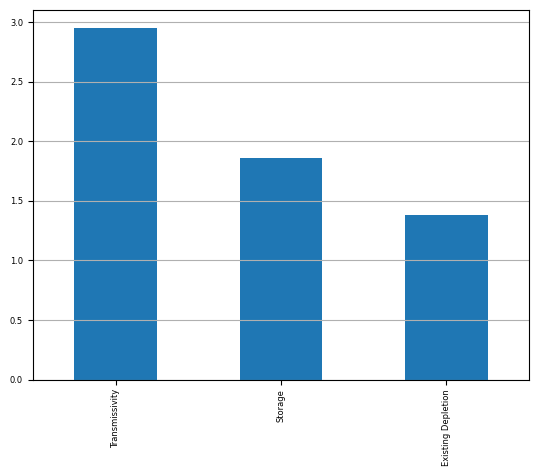

In [26]:
sti.iloc[1:].sum().iloc[1:].sort_values(ascending=False).astype(np.float64).apply(np.log10).plot.bar().grid(axis='y')

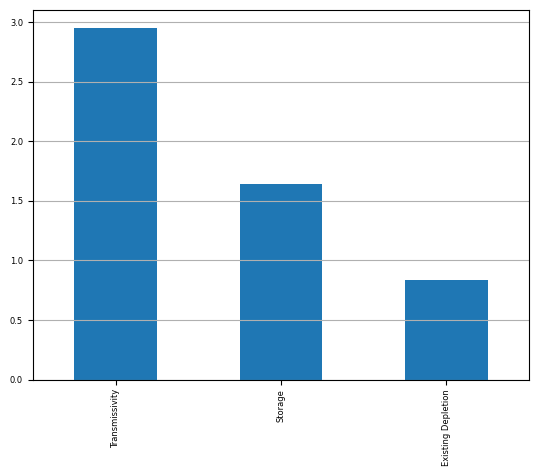

In [27]:
si.iloc[1:].sum().iloc[1:].sort_values(ascending=False).astype(np.float64).apply(np.log10).plot.bar().grid(axis='y')

In [28]:
si.iloc[1:].sum().iloc[1:].sort_values(ascending=False)

Transmissivity        903.614829
Storage                43.949807
Existing Depletion      6.832409
dtype: object

# Now make a combined plot for the paper

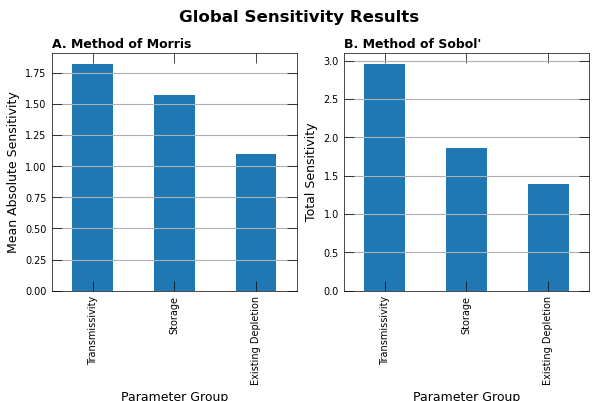

In [29]:
with fpstyles.USGSPlot():
    fig,ax =plt.subplots(1,2,figsize=(6,4))
    morris_df.sort_values(by='sen_mean_abs',ascending=False).iloc[:25].sen_mean_abs.apply(np.log10).plot.bar(ax=ax[0]).grid(axis='y')

    sti.iloc[1:].sum().iloc[1:].sort_values(ascending=False).astype(np.float64).apply(np.log10).plot.bar(ax=ax[1]).grid(axis='y')
    fpstyles.xlabel(ax[1], 'Parameter Group')
    fpstyles.ylabel(ax[1], 'Total Sensitivity')
    fpstyles.xlabel(ax[0], 'Parameter Group')
    fpstyles.ylabel(ax[0], 'Mean Absolute Sensitivity')
 
    fpstyles.heading(ax[0], heading="Method of Morris",   letter='A')
    fpstyles.heading(ax[1], heading="Method of Sobol'",   letter='B')
    plt.suptitle( "Global Sensitivity Results", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('./global_sens.pdf')


In [30]:
ax

array([<Axes: xlabel='Parameter Group', ylabel='Mean Absolute Sensitivity'>,
       <Axes: xlabel='Parameter Group', ylabel='Total Sensitivity'>],
      dtype=object)